<a href="https://colab.research.google.com/github/Mustafa017/feedback_analysis/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!nvidia-smi

Mon Jan 24 17:14:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install -q -U watermark

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.


In [5]:
!pip install -qq transformers

     |████████████████████████████████| 3.4 MB 6.9 MB/s 
     |████████████████████████████████| 3.3 MB 50.1 MB/s 
     |████████████████████████████████| 596 kB 77.5 MB/s 
     |████████████████████████████████| 67 kB 6.7 MB/s 
     |████████████████████████████████| 895 kB 71.1 MB/s 


In [6]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.10.0+cu111
transformers: 4.15.0



In [7]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 49.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 63.2MB/s]


In [8]:
!ls -a 

.  ..  apps.csv  .config  reviews.csv  sample_data


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
RANDOM_SEED=42

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('ggplot')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on {device}')

Running on cuda:0


In [10]:
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [11]:
print(df.shape, '\n')
df.info()

(15746, 11) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


The Score and Review text have no missing values. That is great

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


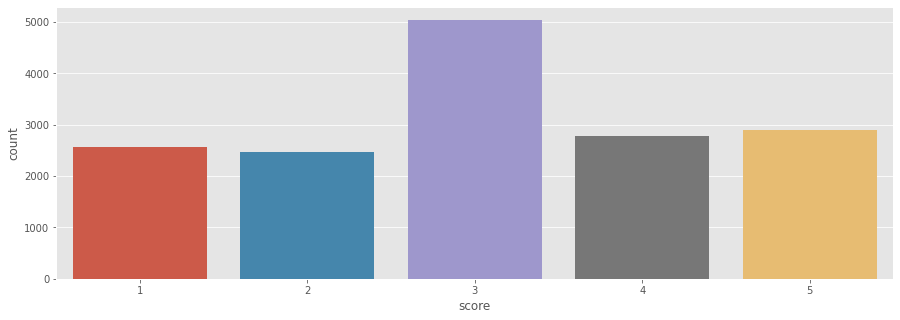

In [12]:
sns.countplot(df.score)

Most of the reviews have a score of 3 which indicates neutral comments. This is an imbalanced dataset. So we will create three sentiments positive, neutral, and negative. Then try and balance the scores among these three sentiments. Training the model on more of one data type will create a bias, which is what we are trying to avoid.

In [13]:
def score_to_sentiment(rating):
  """
  convert score to a sentiment
  negative = 0
  neutral = 1
  positive = 2

  Parameters
  ----------
  rating str

  return
  ------
  sentiment int 
  """
  rating = int(rating)
  if rating < 3:
    return 0
  elif rating > 3:
    return 2
  else:
    return 1

In [14]:
df['sentiment'] = df.score.apply(score_to_sentiment)
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo,0
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo,0
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo,0
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo,0
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo,0


In [15]:
sentiment_classes = ["negative", "neutral", "positive"]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

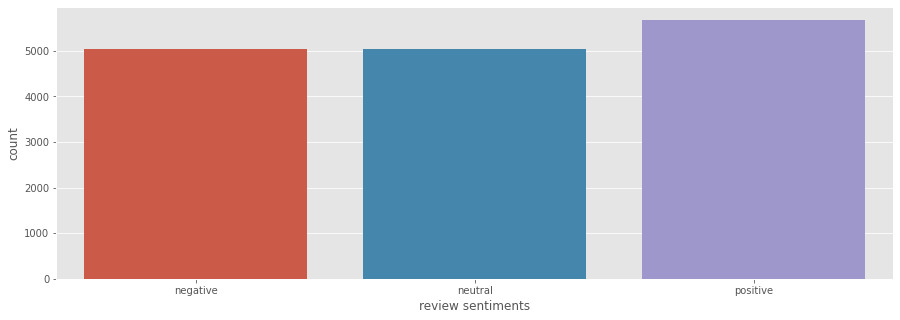

In [16]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiments')
ax.set_xticklabels(sentiment_classes)

The reviews are alomst equal and this solution provides a balanced dataset.

# Data Preprocessing
Machine learning models work with numbers only. So we need to convert the text to numbers. To achieve we need to use a tokenizer.

The Transformers library provides a variety of models e.g. BERT which includes prebuild tokenizers that help us with the conversions.

## Tokenizing (splitting strings in sub-word token strings)
A tokenizer is in charge of preparing the inputs for a model.
* Tokenizing (splitting strings in sub-word token strings), converting tokens strings to ids and back, and encoding/decoding (i.e., tokenizing and converting to integers).
* Adding new tokens to the vocabulary in a way that is independent of the underlying structure (BPE, SentencePiece…).
* Managing special tokens (like mask, beginning-of-sentence, etc.): adding them, assigning them to attributes in the tokenizer for easy access and making sure they are not split during tokenization.

In [17]:
#The cased version works better.
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

### PRETRAINED MODEL
[`PreTrainedModel`](https://huggingface.co/docs/transformers/v4.15.0/en/main_classes/model#transformers.PreTrainedModel.from_pretrained) takes care of storing the configuration of the models and handles methods for loading, downloading and saving models as well as a few methods common to all models to:

* resize the input embeddings,
* prune heads in the self-attention heads.

In [18]:
#load a pre-trained BertTokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [19]:
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-cased', vocab_size=28996, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

Let's test how a tokenizer works. We can


*   convert text to tokens
*   convert tokens to token_ids



In [20]:
sample_text = 'When was I last outside? I am stuck at home for 2 weeks.'
s = "You can't have your to do list as notifications" # problem
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Original Sentence: {sample_text}')
print(f'Generated Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

Original Sentence: When was I last outside? I am stuck at home for 2 weeks.
Generated Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


## Add Special tokens

BERT uses special tokens [CLS], [SEP], and [PAD] to understand input properly.

*   [SEP] A special token separating two different sentences in the same input.
*   [CLS] A special token representing the class of the input.
*   [PAD] A special token used to make arrays of tokens the same size for batching purpose. **Will then be ignored by attention mechanisms or loss computation.**
*   [UNK] A special token representing an out-of-vocabulary token.
*   [MASK] A special token representing a masked token.

In [21]:
print(f'{tokenizer.sep_token}, {tokenizer.sep_token_id}')
print(f'{tokenizer.cls_token}, {tokenizer.cls_token_id}')
print(f'{tokenizer.pad_token}, {tokenizer.pad_token_id}')
print(f'{tokenizer.unk_token}, {tokenizer.unk_token_id}')

[SEP], 102
[CLS], 101
[PAD], 0
[UNK], 100


* Special tokens are carefully handled by the tokenizer (they are never split).

* You can easily refer to special tokens using tokenizer class attributes like tokenizer.cls_token. This makes it easy to develop model-agnostic training and fine-tuning scripts.

All of that work (adding special tokens to the dataframe) can be done using the **encode_plus()** method:

In [22]:
encoding = tokenizer.encode_plus(sample_text, add_special_tokens=True, return_token_type_ids=False, return_tensors='pt', 
                                 return_attention_mask=True, max_length=32, padding='max_length')
encoding

{'input_ids': tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

In [23]:
print(encoding.keys(), '\n')

print(f"input_ids size: {len(encoding['input_ids'][0])}")
print(encoding['input_ids'][0], '\n')

print(f"attention mask size: {len(encoding['attention_mask'][0])}")
print(encoding['attention_mask'][0], '\n')

dict_keys(['input_ids', 'attention_mask']) 

input_ids size: 32
tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]) 

attention mask size: 32
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]) 



We can inverse the tokenization to have a look at the special tokens:


In [24]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

## Choose Suitable Padding Length
BERT works with fixed-length sequences. We need to choose a suitable length.

In [25]:
padding_lengths = []

for t in df.content:
  token = tokenizer.encode(t, max_length=512, truncation=True)
  padding_lengths.append(len(token))


In [26]:
print(min(padding_lengths))

3


Plot the distribution of the padding lengths.

Text(0.5, 0, 'Token Length')

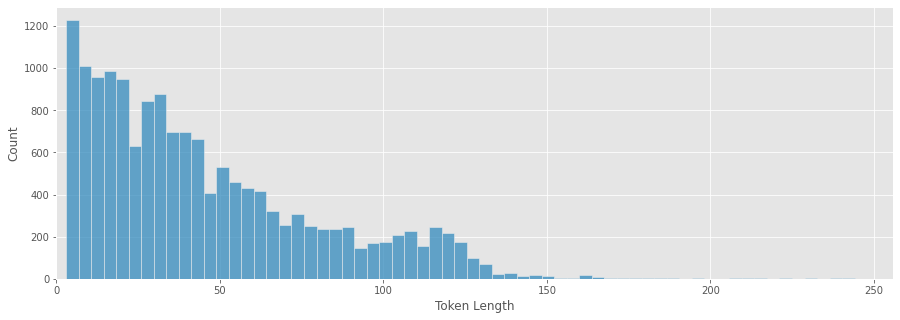

In [27]:
sns.histplot(padding_lengths)
plt.xlim([0, 256])
plt.xlabel('Token Length')

Most token sizes seem to have a length less than 150. We'll  add an allowance upto 160.

In [28]:
PAD_LEN = 160

# Creating a Custom Dataset for your files
[source](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`. 

* `__init__` - The function is run once when instantiating the Dataset object. We initialize the directory containing the feature(e.g images, text), the labels file, and both transforms (**transform** and **target_transform** specify the feature and label transformations)

* `__len__` - The function returns the number of samples in our dataset.

* `__getitem__` - The function loads and returns a sample from the dataset at the given index *idx*. Based on the index, it identifies the feature’s location on disk, converts that to a tensor using read_image, retrieves the corresponding label from the csv data in self.labels, calls the transform functions on them (if applicable), and returns the tensor feature and corresponding label in a tuple.

In [29]:
# create a PyTorch dataset
class CustomDataset(Dataset):
  def __init__(self, features, labels, transform=None, target_transform=None):
    self.features = features
    self.labels = labels
    self.tokenizer = transform
    self.PAD_LEN = target_transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    feature = str(self.features[idx])
    label = self.labels[idx]

    encoding = self.tokenizer.encode_plus(
        feature,
        add_special_tokens=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='pt',
        max_length=self.PAD_LEN, 
        padding='max_length',
        truncation=True
    )

    return {
        'feature_text': feature,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'label': torch.tensor(label, dtype=torch.long)
    }

The `CustomDataset` retrieves our dataset’s features and labels one sample at a time. The sample will include a feature (the text), input_ids and attention_mask(formed after encoding), and label (e.g the sentiment).

Since the Dataset handles one sample at a time, we need to create a `Dataloader`
which  wraps an iterable around the `CustomDataset` to enable easy access to the samples.

While training a model, we typically want to pass samples in `“minibatches”`, reshuffle the data at every epoch to reduce model overfitting, and use Python’s `multiprocessing` to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

we will use a `helper function` to create the Dataloader. A helper function performs part of the computation of another function. It allows you to reuse common code without repeating ourselves.

In [30]:
def custom_dataloader(df, tokenizer, pad_len, batch_size):
  encoded_data = CustomDataset(
      features=df.content.to_numpy(),
      labels=df.sentiment.to_numpy(),
      transform=tokenizer,
      target_transform=pad_len
  )
  return DataLoader(encoded_data, batch_size=batch_size, num_workers=2)


We now need to split our data into training, validation, and testing sets. We'll use 90% of the data for training, then split the remaining 10% between validation and testing.

In [31]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [32]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

In [33]:
BATCH_SIZE = 16

train_dataloader = custom_dataloader(df_train, tokenizer, PAD_LEN, BATCH_SIZE)
validation_dataloader = custom_dataloader(df_val, tokenizer, PAD_LEN, BATCH_SIZE)
test_dataloader = custom_dataloader(df_test, tokenizer, PAD_LEN, BATCH_SIZE)

We have loaded that dataset into the DataLoader and can iterate through the dataset as needed. Each iteration above returns a batch of train_features and train_labels (containing batch_size features and labels respectively).

Let's look at an example from the dataloader.

In [34]:
data = next(iter(train_dataloader))
data.keys()

dict_keys(['feature_text', 'input_ids', 'attention_mask', 'label'])

In [35]:
print(data['feature_text'][0])
print(data['input_ids'][0])
print(data['attention_mask'][0])
print(data['label'][0])

You can't have your to do list as notifications
tensor([  101,  1192,  1169,   112,   189,  1138,  1240,  1106,  1202,  2190,
         1112,  1136, 25583,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,  

In [36]:
print(len(data['feature_text']))
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

16
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


Notice that the `feature_text` is a `list` while the rest are `tensors`. Also the shape indicates that we are loading the data in minibatches of size 16 and the padding length is 160.


# Build a sentiment classifier

We will be using `transfer learning` to build our sentiment classifier on top of [BertModel](https://huggingface.co/docs/transformers/model_doc/bert#bertmodel). 

For transfer learning you generally have two steps. You use dataset A to pretrain your model. Then you use that pretrained model to carry that knowledge into solving dataset B. In this case, BERT is a bidirectional transformer pretrained using a combination of masked language modeling objective and next sentence prediction on a large corpus comprising the Toronto Book Corpus and Wikipedia.

In [37]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:

last_hidden_state, pooled_output = bert_model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask']).to_tuple()

> You can’t unpack a ModelOutput directly. Use the `to_tuple()` method to convert it to a tuple before.

The output with pooling and cross attention [source](https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions).

* `last_hidden_state` (torch.FloatTensor of shape (batch_size, sequence_length, hidden_size)) - Sequence of hidden-states at the output of the last layer of the model.

* `pooler_output` (torch.FloatTensor of shape (batch_size, hidden_size)) — Last layer hidden-state of the first token of the sequence (classification token) after further processing through the layers used for the auxiliary pretraining task. E.g. for BERT-family of models, this returns the classification token after processing through a linear layer and a tanh activation function. The linear layer weights are trained from the next sentence prediction (classification) objective during pretraining.

In [39]:
print(last_hidden_state.shape)
print(pooled_output.shape)

torch.Size([1, 32, 768])
torch.Size([1, 768])


Why 768? This is the hidden size of the model.

In [40]:
print(f'hidden size of the model : {bert_model.config.hidden_size}')
print(f'Number of hidden layers : {bert_model.config.num_hidden_layers}')

hidden size of the model : 768
Number of hidden layers : 12


## Define the Classifier [link](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html#define-the-class)
We define our neural network by subclassing nn.Module, and initialize the neural network layers in `__init__`. Every nn.Module subclass implements the operations on input data in the forward method.

In [41]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).to_tuple()
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier uses Bert's model layers. We add a dropout layer for some regularization and a fully-connected layer for our output.

>Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

We create an instance of `SentimentClassifier`, and move it to the device, and print its structure.

In [42]:
model = SentimentClassifier(len(sentiment_classes))
model = model.to(device)
model

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

To use the model, we pass it the input data. This executes the model’s forward, along with some background operations. Do not call model.forward() directly!

Lets move the batches of the training data to the GPU.

In [43]:
input_ids=data['input_ids'].to(device)
attention_mask=data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 160])
torch.Size([16, 160])


In [44]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.7013, 0.1080, 0.1907],
        [0.5102, 0.2237, 0.2661],
        [0.6616, 0.1314, 0.2070],
        [0.6358, 0.1253, 0.2389],
        [0.5513, 0.2498, 0.1989],
        [0.7075, 0.1006, 0.1919],
        [0.6008, 0.1224, 0.2768],
        [0.5250, 0.2411, 0.2339],
        [0.5310, 0.1845, 0.2844],
        [0.6214, 0.1790, 0.1996],
        [0.7119, 0.1394, 0.1487],
        [0.6793, 0.1340, 0.1867],
        [0.5889, 0.2598, 0.1513],
        [0.5297, 0.2370, 0.2334],
        [0.5532, 0.2407, 0.2061],
        [0.5433, 0.1581, 0.2986]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

# Training
Let's define the hyperparameters recommended from the BERT Paper
* Batch Size: 16, 32
* Learning Rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs : 2,3,4 

We'll try different number of EPOCHS but stick with the other recommendations. 
Note that increasing the batch size reduces the training size significantly, but the model gives a lower accuracy.

We'll also use a linear scheduler with no warmup steps.

In [66]:
EPOCHS=11

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

[training warm-up steps](https://datascience.stackexchange.com/questions/55991/in-the-context-of-deep-learning-what-is-training-warmup-steps)

This usually means that you use a very low learning rate for a set number of training steps (warmup steps). After your warmup steps you use your "regular" learning rate or learning rate scheduler. You can also gradually increase your learning rate over the number of warmup steps.

As far as I know, this has the benefit of slowly starting to tune things like attention mechanisms in your network.

Let's write a helper function for training our model for one epoch.

In [73]:
def train_epoch(model, dataLoader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  
  for d in dataLoader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    labels = d['label'].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    _, pred = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(pred==labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using clip_grad_norm_.



In [74]:
def eval_model(model, dataLoader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for d in dataLoader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      labels = d['label'].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, pred = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(pred==labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using the helper functions above, we can now pass parameters to start the training and validation phase.

In [77]:
%%time
history = defaultdict(list)
overall_accuracy = 0

for e in range(EPOCHS):
  print(f'Epoch {e + 1}/{EPOCHS}')
  print('-'*10)

  train_acc, train_loss = train_epoch(model, train_dataloader, loss_fn, optimizer, device, scheduler, len(df_train))
  print(f'Training Loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, validation_dataloader, loss_fn, device, len(df_val))
  print(f'Val loss {val_loss} accuracy {val_acc}', '\n')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > overall_accuracy:
    print(f'increased accuracy {overall_accuracy} ----> {val_acc} ... saving model')
    torch.save(model.state_dict(), 'best_model_state2.bin')
    overall_accuracy = val_acc

Epoch 1/11
----------
Training Loss 0.6753143665063327 accuracy 0.7066544351139652
Val loss 0.5588135701417923 accuracy 0.7776365946632783 

increased accuracy 0 ----> 0.7776365946632783 ... saving model
Epoch 2/11
----------
Training Loss 0.3886791071045143 accuracy 0.8558323336391221
Val loss 0.5168078578263521 accuracy 0.843710292249047 

increased accuracy 0.7776365946632783 ----> 0.843710292249047 ... saving model
Epoch 3/11
----------
Training Loss 0.2267458255068477 accuracy 0.927528050243455
Val loss 0.5684694312792271 accuracy 0.8831003811944091 

increased accuracy 0.843710292249047 ----> 0.8831003811944091 ... saving model
Epoch 4/11
----------
Training Loss 0.16029481713002564 accuracy 0.9538494107684709
Val loss 0.6808813563873991 accuracy 0.8754764930114358 

Epoch 5/11
----------
Training Loss 0.11430778275339856 accuracy 0.968668407310705
Val loss 0.7796554572932655 accuracy 0.8792884371029225 

Epoch 6/11
----------
Training Loss 0.09230911252692602 accuracy 0.97473713

In [78]:
!ls -lt

total 853500
-rw-r--r-- 1 root root 433334381 Jan 24 19:41 best_model_state2.bin
-rw-r--r-- 1 root root 433334381 Jan 24 18:33 best_model_state.bin
-rw-r--r-- 1 root root   7170328 Jan 24 17:15 reviews.csv
-rw-r--r-- 1 root root    134432 Jan 24 17:15 apps.csv
drwxr-xr-x 1 root root      4096 Jan  7 14:33 sample_data


Accuracy and loss intuitively seem to be somewhat (inversely) correlated, as better predictions should lead to lower loss and higher accuracy.

(0.0, 1.0)

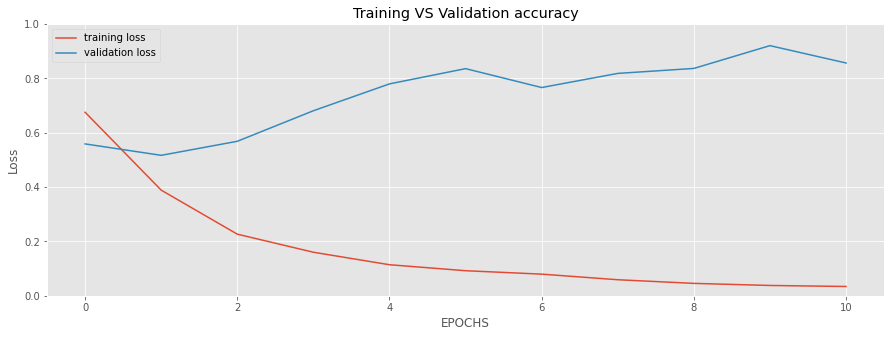

In [80]:
plt.plot(history['train_loss'], label='training loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training VS Validation accuracy')
plt.ylabel('Loss')
plt.xlabel('EPOCHS')
plt.legend()
plt.ylim([0,1])